In [42]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import contextily as ctx
import pygris
import scipy.stats as stats

In [2]:
census = pd.read_csv('../data/censusdata.csv')[['GEOID', 'TotalPopulation']]

econ = gpd.read_file('../data/envi_clusters/econ_clusters.geojson')
econ = econ[econ['labels'] != 'SINGLETON']

physical = gpd.read_file('../data/envi_clusters/physical.geojson')
social = gpd.read_file('../data/envi_clusters/social.geojson')

for clst in [econ, physical, social, census]:
    clst['GEOID'] = clst['GEOID'].astype(str)

narcotic_crime = pd.read_csv('../data/narcotic_crime2023.csv')
narcotic_crime = gpd.GeoDataFrame(
    narcotic_crime, 
    geometry=gpd.points_from_xy(narcotic_crime.longitude, narcotic_crime.latitude), 
    crs='EPSG:4326'
).to_crs('EPSG:26916')

narcotic_crime['GEOID'] = narcotic_crime['GEOID'].astype(str)

holc = gpd.read_file('../data/shapes/mappinginequality.json').to_crs('EPSG:26916')[['grade', 'geometry', 'city']]
holc = holc[(holc['city'] == 'Chicago') & (holc['grade'].isin(['A', 'B', 'C', 'D']))]

Cluster Summary Tables

In [3]:
def summarize_clusters(df, label_name='labels', relevant_aggs=['count', 'mean', 'std']):
  summ = df.groupby(label_name).describe().T
  summ = summ.drop_duplicates().reset_index().rename({
      'labels':'cluster',
      'level_0':'variable',
      'level_1':'aggregate'
  }, axis=1)

  cols = summ['aggregate'].isin(relevant_aggs)
  return summ[cols]


In [4]:
summarize_clusters(physical)

labels           variable aggregate  Disinvested Cityscape  \
0           physical_311s     count              74.000000   
1           physical_311s      mean               0.904551   
2           physical_311s       std               0.789216   
8       relative_greenery      mean              -0.134044   
9       relative_greenery       std               0.618486   
15                VacantP      mean               0.533049   
16                VacantP       std               0.945020   

labels  Northside Greenery  Southside Greenery  Standard Cityscape  \
0                25.000000          103.000000          474.000000   
1                 0.116253            0.763605           -0.523831   
2                 0.328736            0.892190            0.584615   
8                 2.430560            1.296200           -0.379595   
9                 1.563396            1.049913            0.581780   
15               -0.551268           -0.176893           -0.329224   
16                0.557209            1.052907            0.606477   

labels  Vacant Needs Repairs  
0                 111.000000  
1                   0.899113  
2                   1.188367  
8                  -0.039867  
9                   0.582570  
15                  1.338811  
16                  1.148592

Side by Side of Clusters

In [5]:
social['labels'].unique()

array(['Northside', 'Southwestside'], dtype=object)

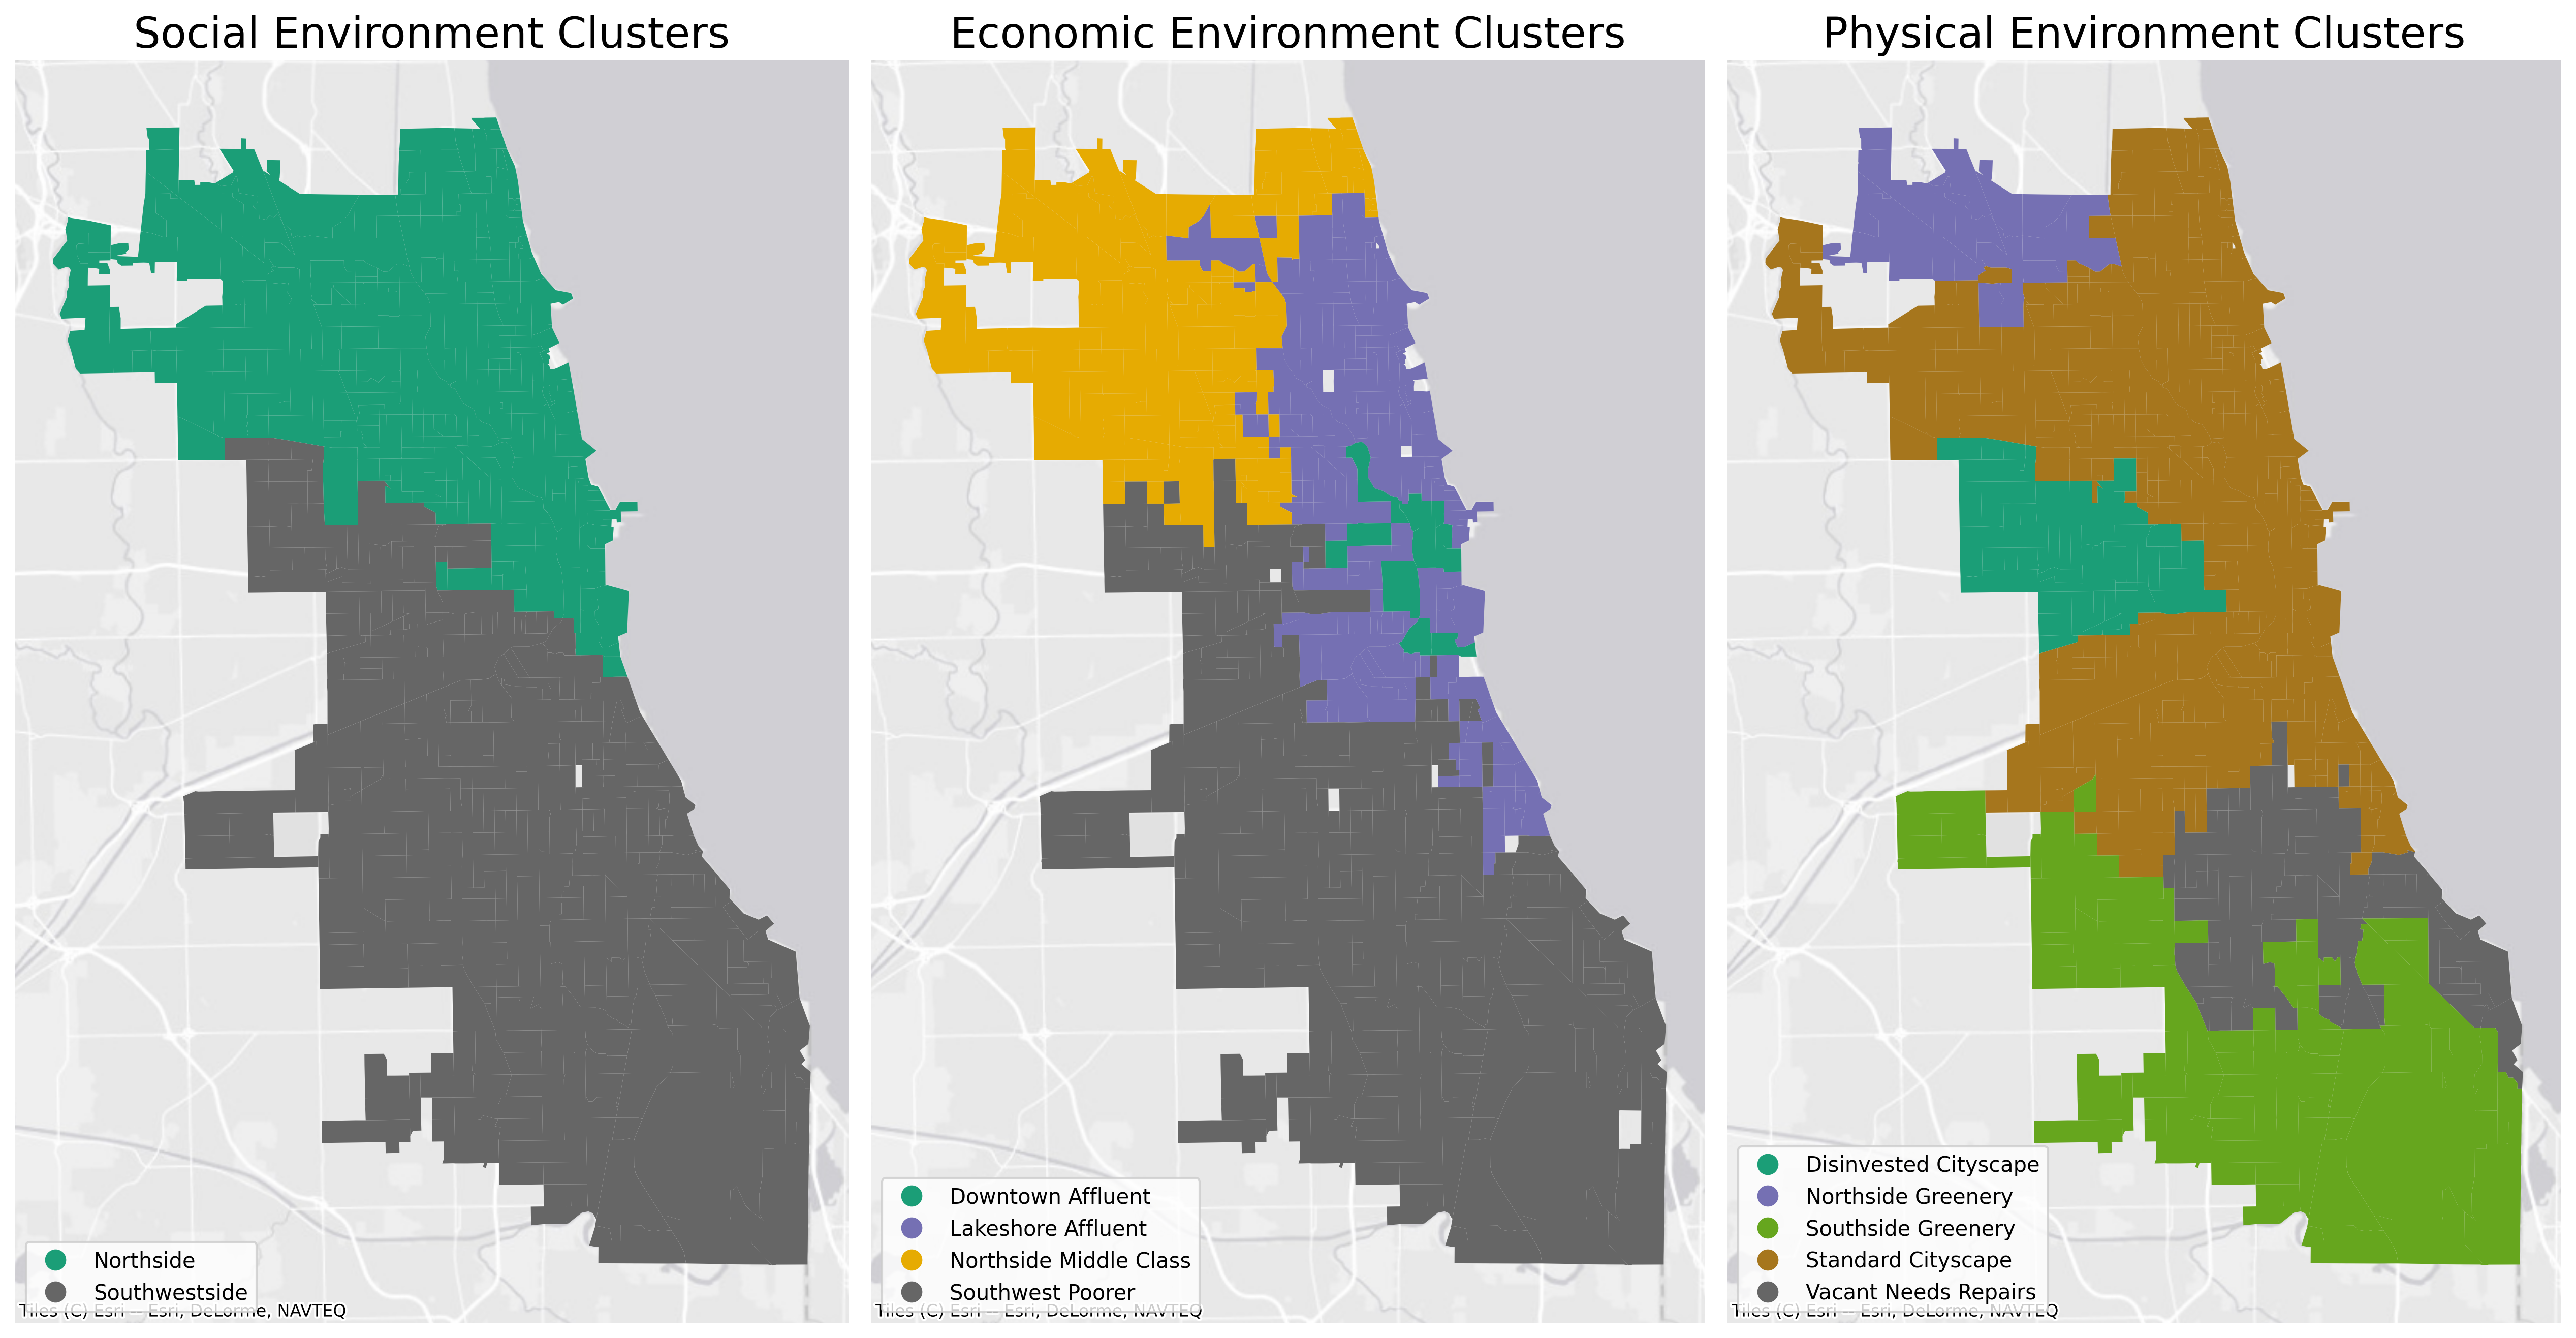

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(17, 10), dpi=300)

clusters = [social, econ, physical]
titles = ('Social Environment Clusters', 'Economic Environment Clusters', 'Physical Environment Clusters')

for ax, clust, title in zip(axes, clusters, titles):
    clust.plot('labels', cmap='Dark2', legend=True, ax=ax,
                legend_kwds={
                    'fontsize':10,
                    'loc':3
                })
    ax.set_title(title, fontsize=20)

    ctx.add_basemap(ax, crs=physical.crs, source=ctx.providers.Esri.WorldGrayCanvas)
    ax.axis('off')

fig.tight_layout()

plt.savefig('../figures/cluster_maps.svg')


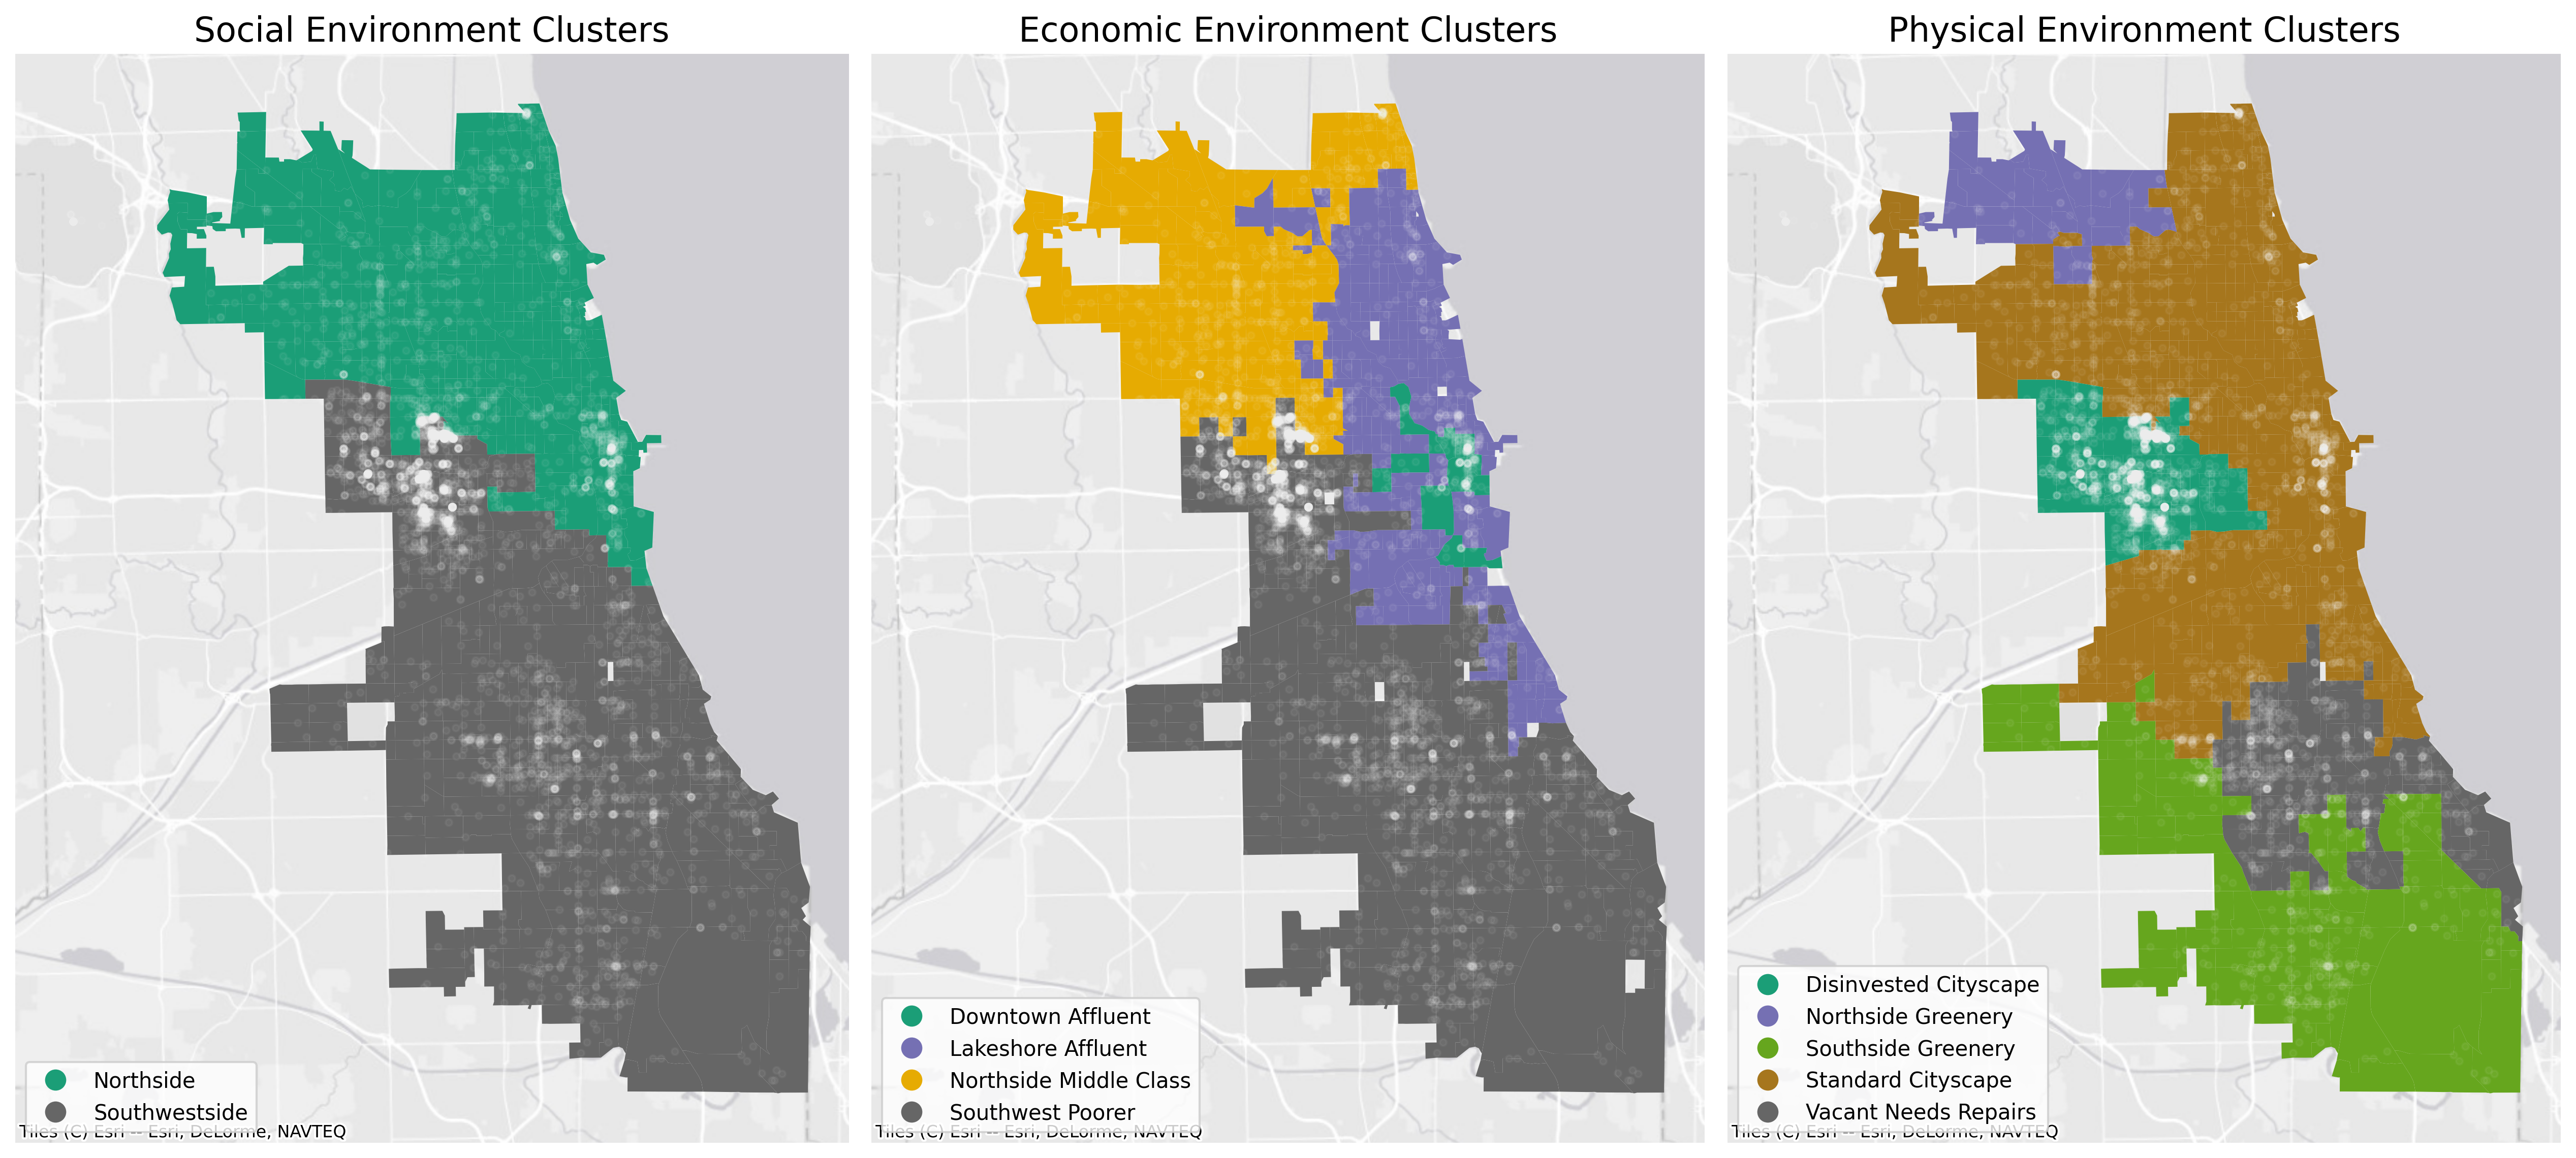

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(17, 10), dpi=300)

clusters = [social, econ, physical]
titles = ('Social Environment Clusters', 'Economic Environment Clusters', 'Physical Environment Clusters')

for ax, clust, title in zip(axes, clusters, titles):
    clust.plot('labels', cmap='Dark2', legend=True, ax=ax,
                legend_kwds={
                    'fontsize':10,
                    'loc':3
                })
    narcotic_crime.plot(ax=ax, markersize=10, color='white', edgecolor='white', alpha=.05)
    ax.set_title(title, fontsize=16)

    ctx.add_basemap(ax, crs=physical.crs, source=ctx.providers.Esri.WorldGrayCanvas)
    ax.axis('off')

fig.tight_layout()

plt.savefig('../figures/narcotic_cluster_maps.svg')

Narcotic Split Table

In [8]:
tracts = pygris.tracts(state='il', county='cook', cb=True, cache=True).to_crs('EPSG:26916')

# Get the total number of narcotic arrests per census tract
narcotic_crime['i'] = 1
narcotic_sum_by_tract = narcotic_crime[['i', 'GEOID']].groupby('GEOID').sum().reset_index()
census = census.merge(narcotic_sum_by_tract, how='outer')
census['i'] = census['i'].fillna(0)

# Get narcotic rate per 1000 population
census['narcPer1000'] = 1000 * census['i'] / census['TotalPopulation']
census = census.merge(tracts[['GEOID', 'geometry']], on='GEOID', how='left')

# spatially enable so we can plot for sanity
census = gpd.GeoDataFrame(census, geometry=census.geometry, crs='EPSG:26916')

Using the default year of 2021
Using FIPS code '17' for input 'il'
Using FIPS code '031' for input 'cook'


In [9]:
census.head()

GEOID  TotalPopulation     i  narcPer1000  \
0  17031010100           4284.0  13.0     3.034547   
1  17031010201           8210.0   3.0     0.365408   
2  17031010202           2865.0  20.0     6.980803   
3  17031010300           6237.0   4.0     0.641334   
4  17031010400           4473.0   3.0     0.670691   

                                            geometry  
0  POLYGON ((443936.001 4652545.254, 444376.060 4...  
1  POLYGON ((443315.826 4652166.333, 443663.936 4...  
2  POLYGON ((443961.380 4652152.982, 444254.861 4...  
3  POLYGON ((444418.780 4652145.271, 444570.448 4...  
4  POLYGON ((445065.309 4651413.606, 445241.499 4...

<Axes: >

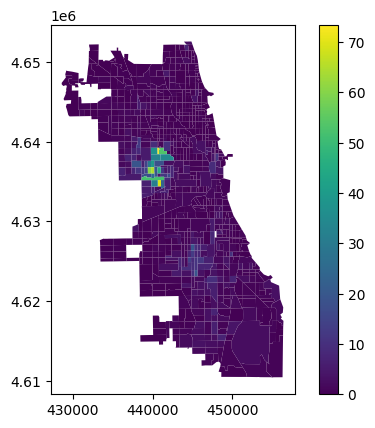

In [10]:
census[census['narcPer1000'] != np.inf].plot('narcPer1000', legend=True, edgecolor='none')

In [11]:
econ_narc = econ\
    .merge(census[['GEOID', 'TotalPopulation', 'i']], how='left', on='GEOID')\
    [['labels', 'TotalPopulation', 'i']]\
    .groupby('labels')\
    .sum()

econ_narc['ratePer100k'] = 1000 * econ_narc['i'] / econ_narc['TotalPopulation']
econ_narc

TotalPopulation       i  ratePer100k
labels                                                      
Downtown Affluent               66692.0   264.0     3.958496
Lakeshore Affluent             809761.0   488.0     0.602647
Northside Middle Class         740315.0   961.0     1.298096
Southwest Poorer              1079746.0  3368.0     3.119252

In [12]:
physical_narc = physical\
    .merge(census[['GEOID', 'TotalPopulation', 'i']], how='left', on='GEOID')\
    [['labels', 'TotalPopulation', 'i']]\
    .groupby('labels')\
    .sum()

physical_narc['ratePer100k'] = 1000 * physical_narc['i'] / physical_narc['TotalPopulation']
physical_narc

TotalPopulation       i  ratePer100k
labels                                                     
Disinvested Cityscape         202172.0  2354.0    11.643551
Northside Greenery            128886.0    46.0     0.356905
Southside Greenery            408533.0   429.0     1.050099
Standard Cityscape           1710474.0  1550.0     0.906182
Vacant Needs Repairs          263716.0   722.0     2.737794

In [13]:
social_narc = social\
    .merge(census[['GEOID', 'TotalPopulation', 'i']], how='left', on='GEOID')\
    [['labels', 'TotalPopulation', 'i']]\
    .groupby('labels')\
    .sum()

social_narc['ratePer100k'] = 1000 * social_narc['i'] / social_narc['TotalPopulation']
social_narc

TotalPopulation       i  ratePer100k
labels                                             
Northside            1408502.0  1287.0     0.913737
Southwestside        1307545.0  3814.0     2.916917

HOLC Table

In [44]:
grade_clusters = {
    'A':'AB',
    'B':'AB',
    'C':'CD',
    'D':'CD'
}

tracts['geometry'] = tracts.centroid
tract_grades = tracts[['GEOID', 'geometry']].sjoin(holc, predicate='within')[['GEOID', 'grade']]
tract_grades['grade'] = tract_grades['grade'].apply(grade_clusters.get)
tract_grades.head()

GEOID grade
0  17031230200    CD
4  17031310400    CD
5  17031810100    CD
6  17031060800    AB
7  17031301802    CD

In [45]:
social.merge(tract_grades, on='GEOID')[['grade']].value_counts()

grade
CD       582
AB        66
Name: count, dtype: int64

In [54]:
social.merge(tract_grades, on='GEOID')[['grade', 'labels']].groupby('grade').value_counts()

grade  labels       
AB     Northside         41
       Southwestside     25
CD     Southwestside    317
       Northside        265
Name: count, dtype: int64

In [66]:
obs = [np.array([41, 25]), np.array([265, 317])]
stat, p, dof, expected = stats.chi2_contingency(obs)
stat, p, dof, expected

(5.896361721327408,
 0.01517219408406283,
 1,
 array([[ 31.16666667,  34.83333333],
        [274.83333333, 307.16666667]]))

In [47]:
econ.merge(tract_grades, on='GEOID')[['grade']].value_counts()

grade
CD       576
AB        66
Name: count, dtype: int64

In [48]:
econ.merge(tract_grades, on='GEOID')[['grade', 'labels']].groupby('grade').value_counts()

grade  labels                
AB     Northside Middle Class     31
       Southwest Poorer           23
       Lakeshore Affluent         12
CD     Southwest Poorer          247
       Lakeshore Affluent        194
       Northside Middle Class    129
       Downtown Affluent           6
Name: count, dtype: int64

In [61]:
obs = [[23, 12, 31, 0], [247, 194, 129, 6]]

stat, p, dof, expected = stats.chi2_contingency(obs)
stat, p, dof, expected

(20.37717800689269,
 0.00014177252367500397,
 3,
 array([[ 27.75700935,  21.17757009,  16.44859813,   0.61682243],
        [242.24299065, 184.82242991, 143.55140187,   5.38317757]]))

In [49]:
physical.merge(tract_grades, on='GEOID')[['grade']].value_counts()

grade
CD       582
AB        66
Name: count, dtype: int64

In [50]:
physical.merge(tract_grades, on='GEOID')[['grade', 'labels']].groupby('grade').value_counts()

grade  labels               
AB     Standard Cityscape        33
       Southside Greenery        12
       Vacant Needs Repairs      11
       Northside Greenery        10
CD     Standard Cityscape       365
       Vacant Needs Repairs      85
       Disinvested Cityscape     65
       Southside Greenery        55
       Northside Greenery        12
Name: count, dtype: int64

In [62]:
obs = [[33, 12, 11, 10, 0], [365, 55, 85, 12, 65]]

stat, p, dof, expected = stats.chi2_contingency(obs)
stat, p, dof, expected

(43.38837058193218,
 8.595074297535443e-09,
 4,
 array([[ 40.53703704,   6.82407407,   9.77777778,   2.24074074,
           6.62037037],
        [357.46296296,  60.17592593,  86.22222222,  19.75925926,
          58.37962963]]))